In [83]:
import json
import datetime
import pytz
import gender_guesser.detector as gender
import pandas as pd
from tzwhere import tzwhere
from textblob import TextBlob

gender_guesser = gender.Detector(case_sensitive=False)
tzwhere_ = tzwhere.tzwhere()

In [84]:
def check_hashtag(single_tweet):
    '''check whether tweet has any hashtags'''
    return len(single_tweet['entities']['hashtags']) > 0

def check_media(single_tweet):
    '''check whether tweet has any media attached'''
    return len(single_tweet['entities']['media' ]) > 0

def check_url(single_tweet):
    '''check whether tweet has any urls attached'''
    return len(single_tweet['entities']['urls']) > 0

def check_retweet(single_tweet):
    '''
    check whether tweet is a RT. If yes:
    return name & user name of the RT'd user.
    otherwise just return nones
    '''
    if 'retweeted_status' in single_tweet.keys():
        return (single_tweet['retweeted_status']['user']['screen_name'],
                single_tweet['retweeted_status']['user']['name'])
    else:
        return (None,None)
    
def check_coordinates(single_tweet):
    '''
    check whether tweet has coordinates attached.
    if yes return the coordinates
    otherwise just return nones
    '''
    if 'coordinates' in single_tweet['geo'].keys():
        return (single_tweet['geo']['coordinates'][0],
                single_tweet['geo']['coordinates'][1])
    else:
        return (None,None)

def check_reply_to(single_tweet):
    '''
    check whether tweet is a reply. If yes:
    return name & user name of the user that's replied to.
    otherwise just return nones
    '''
    if 'in_reply_to_screen_name' in single_tweet.keys():
        name = None
        for user in single_tweet['entities']['user_mentions']:
            if user['screen_name'] == single_tweet['in_reply_to_screen_name']:
                name = user['name']
                break
        return (single_tweet['in_reply_to_screen_name'],name)
    else:
        return (None,None)

def convert_time(coordinates,time_utc):
    '''
    Does this tweet have a geo location? if yes 
    we can easily convert the UTC timestamp to true local time!
    otherwise return nones
    '''
    if coordinates[0] and coordinates[1]:
        timezone_str = tzwhere_.tzNameAt(coordinates[0],coordinates[1])
        if timezone_str:
            timezone = pytz.timezone(timezone_str)
            time_obj_local = datetime.datetime.astimezone(time_utc,timezone)
            return time_obj_local
    
def create_dataframe(tweets):
    '''
    create a pandas dataframe from our tweet jsons
    '''
    
    # initalize empty lists
    utc_time = []
    longitude = []
    latitude = []
    local_time = []
    hashtag = []
    media = []
    url = []
    retweet_user_name = []
    retweet_name = []
    reply_user_name = []
    reply_name = []
    text = []
    polarity = []
    subjectivity = []
    
    # iterate over all tweets and extract data
    for single_tweet in tweets:
        utc_time.append(datetime.datetime.strptime(single_tweet['created_at'],'%Y-%m-%d %H:%M:%S %z'))
        coordinates = check_coordinates(single_tweet)
        latitude.append(coordinates[0])
        longitude.append(coordinates[1])
        local_time.append(convert_time(coordinates,datetime.datetime.strptime(single_tweet['created_at'],'%Y-%m-%d %H:%M:%S %z')))
        hashtag.append(check_hashtag(single_tweet))
        media.append(check_media(single_tweet))
        url.append(check_url(single_tweet))
        retweet = check_retweet(single_tweet)
        retweet_user_name.append(retweet[0])
        retweet_name.append(retweet[1])
        reply = check_reply_to(single_tweet)
        reply_user_name.append(reply[0])
        reply_name.append(reply[1])
        text.append(single_tweet['text'])
        blob = TextBlob(single_tweet['text'])
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)
        
    # convert the whole shebang into a pandas dataframe
    dataframe = pd.DataFrame(data= {
                    'utc_time' : utc_time,
                    'local_time' : local_time,
                    'latitude' : latitude,
                    'longitude' : longitude,
                    'hashtag' : hashtag,
                    'media' : media,
                    'url' : url,
                    'retweet_user_name' : retweet_user_name,
                    'retweet_name' : retweet_name,
                    'reply_user_name' : reply_user_name,
                    'reply_name' : reply_name,
                    'text' : text,
                    'polarity': polarity,
                    'subjectivity': subjectivity
    })
    return dataframe

def read_file_index(index_file):
    '''
    read file that lists all 
    tweet-containing json files
    '''
    with open(index_file) as f:    
        d = f.readlines()[1:]
        d = "".join(d)
        d = "[{" + d
        files = json.loads(d)
    return files

def read_single_file(fpath):
    '''
    read in the json of a single tweet.json
    '''
    with open(fpath) as f:
        d = f.readlines()[1:]
        d = "".join(d)
        tweets = json.loads(d)
    return tweets

def read_files(file_list,base_path):
    '''
    use the file list as generated by
    read_file_index() to read in the json
    of all tweet.json files and convert them 
    into individual data frames.
    Returns them so far not concatenated
    '''
    data_frames = []
    for single_file in file_list:
        tweets = read_single_file(base_path + '/' + single_file['file_name'])
        df_tweets = create_dataframe(tweets)
        data_frames.append(df_tweets)
    return data_frames

In [85]:
file_index = read_file_index('/Users/bastian/Downloads/14286491_2ff36254a0fdc964eeb551a9ba8fbbb327569c02/data/js/tweet_index.js')
dataframes = read_files(file_index,'/Users/bastian/Downloads/14286491_2ff36254a0fdc964eeb551a9ba8fbbb327569c02/')
dataframe = pd.concat(dataframes)
dataframe.sort_values('utc_time',ascending=False)
dataframe = dataframe.set_index('utc_time')

In [122]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [120]:
dataframe = dataframe.replace(to_replace={'url': {False: None},'hashtag': {False: None},'media': {False: None}})
dataframe_grouped = dataframe.groupby(dataframe.index.date).count()
dataframe_grouped.index = pd.to_datetime(dataframe_grouped.index)
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()

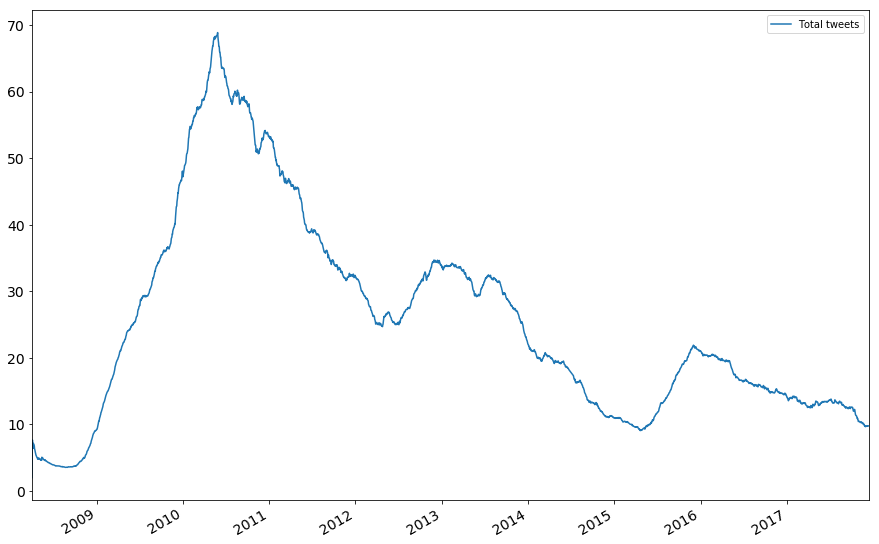

In [123]:
pt = dataframe_mean_week.plot(y=['text'],figsize=(15,10),fontsize=14)
pt.legend(["Total tweets"])

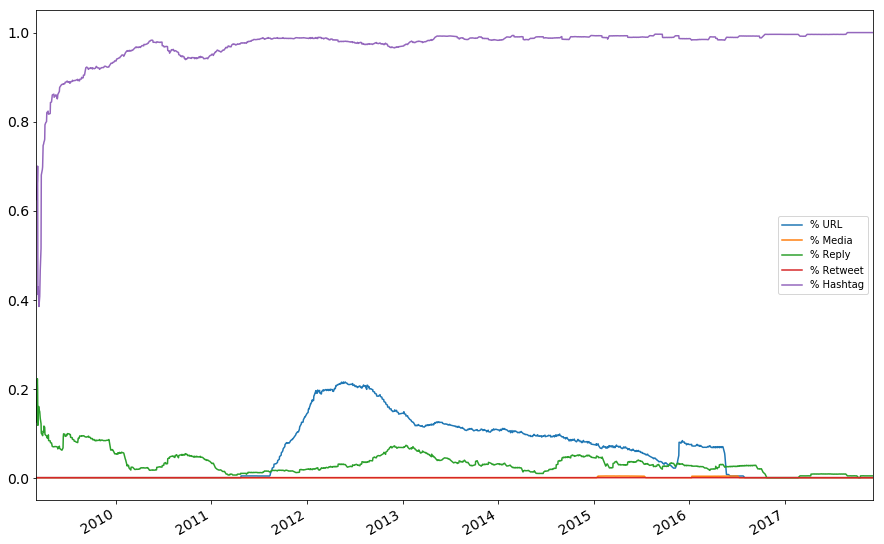

In [21]:
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()
dataframe_mean_week['percent_url'] = dataframe_mean_week['url'] / dataframe_mean_week['text']
dataframe_mean_week['percent_media'] = dataframe_mean_week['media'] / dataframe_mean_week['text']
dataframe_mean_week['percent_reply'] = dataframe_mean_week['reply_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_retweet'] = dataframe_mean_week['retweet_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_hashtag'] = dataframe_mean_week['hashtag'] / dataframe_mean_week['text']

dataframe_mean_week = dataframe_mean_week.drop(['reply_user_name',
                                                'retweet_user_name',
                                                'latitude',
                                                'longitude',
                                                'local_time',
                                                'url',
                                                'media',
                                                'reply_name',
                                                'retweet_name',
                                                'hashtag',
                                                #'text',
                                               ],
                                               axis=1)

pt = dataframe_mean_week.plot(y=['percent_url', 'percent_media', 'percent_reply','percent_retweet','percent_hashtag'],figsize=(15,10),fontsize=14)
pt.legend(["% URL", "% Media",'% Reply','% Retweet','% Hashtag'])

df_mean_week_lg = dataframe_mean_week.unstack().reset_index()
df_mean_week_lg.index = pd.to_datetime(df_mean_week_lg['level_1'])

In [22]:
def predict_gender(dataframe,column_name):
    '''
    take full dataframe w/ tweets and extract
    gender for a name-column where applicable
    returns two-column df w/ timestamp & gender
    '''
    splitter = lambda x: x.split()[0]
    gender_column = dataframe.loc[dataframe[column_name].notnull()][column_name].apply(
        splitter).apply(
        gender_guesser.get_gender)

    gender_dataframe = pd.DataFrame(data = {
                    'time' : list(gender_column.index),
                    'gender' : list(gender_column)
                    })
    
    gender_dataframe = gender_dataframe.set_index('time')
    gender_dataframe_tab = gender_dataframe.groupby([gender_dataframe.index.date,gender_dataframe['gender']]).size().reset_index()
    gender_dataframe_tab['date'] = gender_dataframe_tab['level_0']
    gender_dataframe_tab['count'] = gender_dataframe_tab[0]
    gender_dataframe_tab = gender_dataframe_tab.drop([0,'level_0'],axis=1)
    gender_dataframe_tab = gender_dataframe_tab.set_index('date')
    gender_dataframe_tab.index = pd.to_datetime(gender_dataframe_tab.index)
    return gender_dataframe_tab

retweet_gender = predict_gender(dataframe,'retweet_name')
retweet_gender.pivot(columns='gender', values='count').rolling(
    '180d').mean().plot(
    y=['male', 'female','unknown'],figsize=(15,10),fontsize=14)

AttributeError: 'Float64Index' object has no attribute 'date'

In [115]:
reply_gender = predict_gender(dataframe,'reply_name')
reply_gender.pivot(columns='gender', values='count').rolling(
    '180d').mean().plot(
    y=['male', 'female','unknown'],figsize=(15,10),fontsize=14)

NameError: name 'predict_gender' is not defined

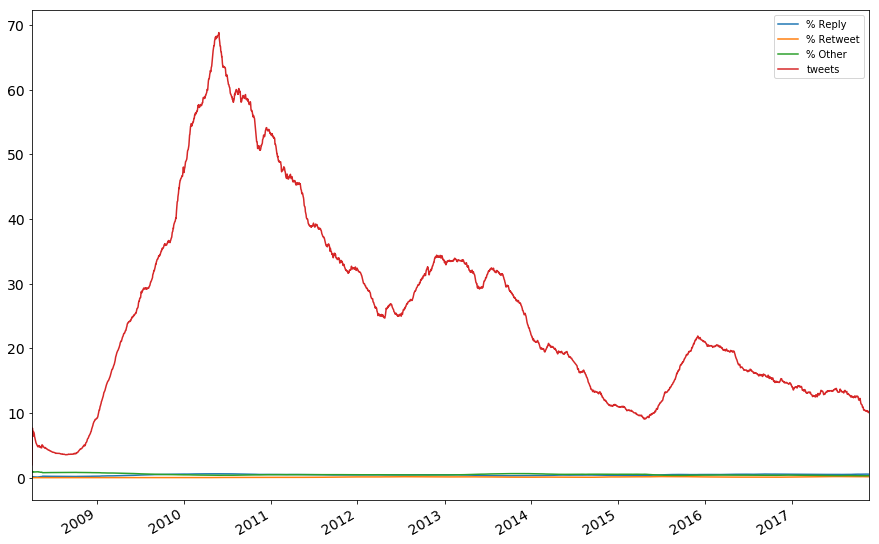

In [10]:
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()
dataframe_mean_week['percent_url'] = dataframe_mean_week['url'] / dataframe_mean_week['text']
dataframe_mean_week['percent_media'] = dataframe_mean_week['media'] / dataframe_mean_week['text']
dataframe_mean_week['percent_reply'] = dataframe_mean_week['reply_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_retweet'] = dataframe_mean_week['retweet_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_hashtag'] = dataframe_mean_week['hashtag'] / dataframe_mean_week['text']
dataframe_mean_week['percent_other'] = 1 - (dataframe_mean_week['percent_reply'] + dataframe_mean_week['percent_retweet'])

dataframe_mean_week = dataframe_mean_week.drop(['reply_user_name',
                                                'retweet_user_name',
                                                'latitude',
                                                'longitude',
                                                'local_time',
                                                'url',
                                                'media',
                                                'reply_name',
                                                'retweet_name',
                                                'hashtag',
#                                                'text',
                                               ],
                                               axis=1)

pt = dataframe_mean_week.plot(y=['percent_reply','percent_retweet','percent_other','text'],figsize=(15,10),fontsize=14)
pt.legend(['% Reply','% Retweet','% Other','tweets'])

df_mean_week_lg = dataframe_mean_week.unstack().reset_index()
df_mean_week_lg.index = pd.to_datetime(df_mean_week_lg['level_1'])

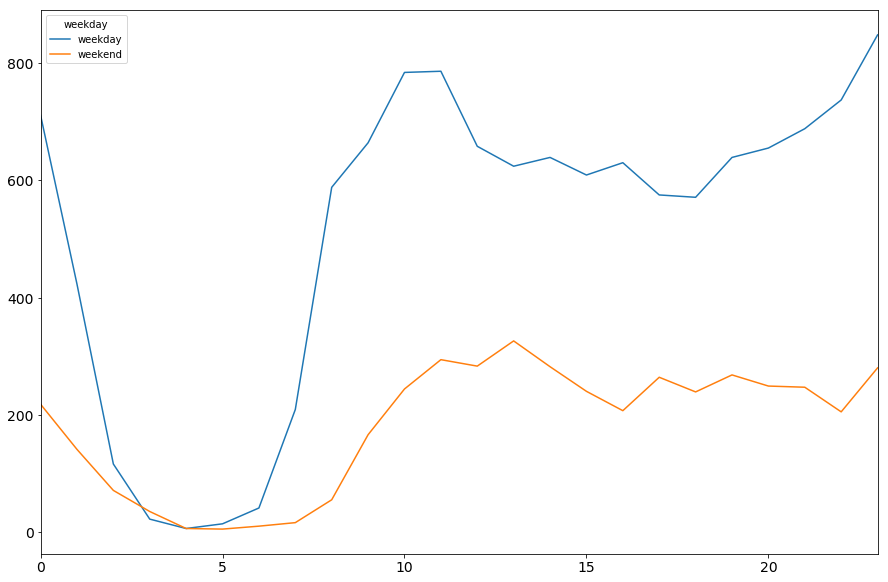

In [11]:
def create_hourly_stats(dataframe):
    get_hour = lambda x: x.hour
    get_weekday = lambda x: x.weekday()

    local_times = dataframe.copy()
    local_times = local_times.loc[dataframe['local_time'].notnull()]

    local_times['weekday'] = local_times['local_time'].apply(get_weekday)
    local_times['hour'] = local_times['local_time'].apply(get_hour)


    local_times = local_times.replace(to_replace={'weekday':
                                                    {0:'weekday',
                                                     1:'weekday',
                                                     2:'weekday',
                                                     3:'weekday',
                                                     4:'weekday',
                                                     5:'weekend',
                                                     6:'weekend',
                                                    }
                                       })

    local_times = local_times.groupby([local_times['hour'],local_times['weekday']]).size().reset_index()
    local_times['values'] = local_times[0]
    local_times = local_times.set_index(local_times['hour'])

    return local_times.pivot(columns='weekday', values='values').reset_index()

local_time = create_hourly_stats(dataframe)
local_time.plot(y=['weekday', 'weekend'],figsize=(15,10),fontsize=14)

In [12]:
# this is the export that metricsgraphicsjs needs!
local_time.to_json(orient='records')

'[{"hour":0,"weekday":711,"weekend":218},{"hour":1,"weekday":423,"weekend":141},{"hour":2,"weekday":116,"weekend":71},{"hour":3,"weekday":22,"weekend":35},{"hour":4,"weekday":6,"weekend":6},{"hour":5,"weekday":14,"weekend":5},{"hour":6,"weekday":41,"weekend":10},{"hour":7,"weekday":209,"weekend":16},{"hour":8,"weekday":588,"weekend":55},{"hour":9,"weekday":664,"weekend":166},{"hour":10,"weekday":784,"weekend":244},{"hour":11,"weekday":786,"weekend":294},{"hour":12,"weekday":658,"weekend":283},{"hour":13,"weekday":624,"weekend":326},{"hour":14,"weekday":639,"weekend":282},{"hour":15,"weekday":609,"weekend":240},{"hour":16,"weekday":630,"weekend":207},{"hour":17,"weekday":575,"weekend":264},{"hour":18,"weekday":571,"weekend":239},{"hour":19,"weekday":639,"weekend":268},{"hour":20,"weekday":655,"weekend":249},{"hour":21,"weekday":688,"weekend":247},{"hour":22,"weekday":737,"weekend":205},{"hour":23,"weekday":848,"weekend":280}]'

In [13]:
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()
dataframe_mean_week['p_url'] = (dataframe_mean_week['url'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_media'] = (dataframe_mean_week['media'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_reply'] = (dataframe_mean_week['reply_name'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_rt'] = (dataframe_mean_week['retweet_name'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_hash'] = (dataframe_mean_week['hashtag'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_other'] = 100 - (dataframe_mean_week['p_reply'] + dataframe_mean_week['p_rt'])

dataframe_mean_week = dataframe_mean_week.reset_index()
dataframe_mean_week['date'] = dataframe_mean_week['index'].astype(str)
dataframe_mean_week = dataframe_mean_week.drop(['reply_user_name',
                                                'retweet_user_name',
                                                'latitude',
                                                'longitude',
                                                'local_time',
                                                'url',
                                                'media',
                                                'reply_name',
                                                'retweet_name',
                                                'hashtag',
                                                'index',
                                               ],
                                               axis=1)

#dataframe_mean_week.to_json(orient='records', double_precision=2)

In [14]:
list(dataframe['reply_user_name'].value_counts()[:20].reset_index()['index'])

['PhilippBayer',
 'plaetzchen',
 'Senficon',
 'Fischblog',
 'Lobot',
 '_Rya_',
 'ComPod',
 'TheConstructor',
 'coraxaroc',
 'CaeVye',
 'gedankenstuecke',
 'herrurbach',
 'insideX',
 'monasterium',
 'eltonjohn',
 'Dave_Kay',
 'scy',
 'eramirez',
 'alios',
 'NieMehrPiraten']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a7d2668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x124c7dda0>], dtype=object)

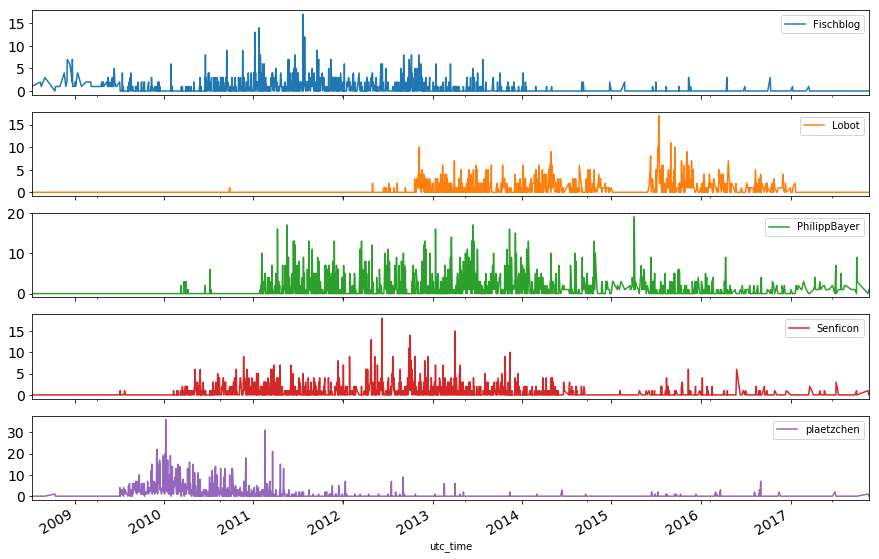

In [15]:
top_replies = dataframe[dataframe['reply_user_name'].isin(list(dataframe['reply_user_name'].value_counts()[:5].reset_index()['index']))]
top_replies = top_replies.reset_index()[['reply_user_name','utc_time']]
top_replies['utc_time'] = top_replies['utc_time'].dt.date
top_replies = top_replies.groupby(["utc_time", "reply_user_name"]).size()
top_replies.reset_index().pivot(index='utc_time', columns='reply_user_name', values=0).fillna(value=0).plot(figsize=(15,10),fontsize=14,subplots=True)


In [16]:
list(dataframe['reply_user_name'].value_counts()[:5].index)

['PhilippBayer', 'plaetzchen', 'Senficon', 'Fischblog', 'Lobot']

In [17]:
top_replies = dataframe[dataframe['reply_user_name'].isin(list(dataframe['reply_user_name'].value_counts()[:5].reset_index()['index']))]
top_replies = top_replies.reset_index()[['reply_user_name','utc_time']]
top_replies['utc_time'] = top_replies['utc_time'].dt.date
top_replies = top_replies.groupby(["utc_time", "reply_user_name"]).size()
top_replies = top_replies.reset_index()
top_replies['value'] = top_replies[0]
top_replies['date'] = top_replies['utc_time'].astype(str)
top_replies = top_replies.drop(['utc_time',0],axis=1)
top_replies['date'] = pd.to_datetime(top_replies['date'])
top_replies = top_replies.groupby(['reply_user_name', pd.Grouper(key='date', freq='MS')])['value'].sum().reset_index().sort_values('date')

In [18]:
top_replies

,reply_user_name,date,value
0,Fischblog,2008-07-01,1
1,Fischblog,2008-08-01,3
2,Fischblog,2008-09-01,3
3,Fischblog,2008-10-01,1
304,plaetzchen,2008-10-01,1
4,Fischblog,2008-11-01,6
5,Fischblog,2008-12-01,34
6,Fischblog,2009-01-01,12
7,Fischblog,2009-02-01,2
8,Fischblog,2009-03-01,4


In [19]:
top_replies = dataframe[dataframe['reply_user_name'].isin(list(dataframe['reply_user_name'].value_counts()[:5].reset_index()['index']))]
top_replies = top_replies.reset_index()[['reply_user_name','utc_time']]
top_replies['utc_time'] = top_replies['utc_time'].dt.date
top_replies = top_replies.groupby(["utc_time", "reply_user_name"]).size()
top_replies = top_replies.reset_index()
top_replies['date'] = top_replies['utc_time'].astype(str)
top_replies['value'] = top_replies[0]
top_replies = top_replies.drop([0,'utc_time'],axis=1)
top_replies['date'] = pd.to_datetime(top_replies['date'])
top_replies = top_replies.groupby(['reply_user_name', pd.Grouper(key='date', freq='MS')])['value'].sum().reset_index().sort_values('date')
top_replies['date'] = top_replies['date'].astype(str)
top_replies.reset_index().pivot(index='date', columns='reply_user_name', values='value').fillna(value=0).reset_index().to_json(orient='records')

'[{"date":"2008-07-01","Fischblog":1.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2008-08-01","Fischblog":3.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2008-09-01","Fischblog":3.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2008-10-01","Fischblog":1.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":1.0},{"date":"2008-11-01","Fischblog":6.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2008-12-01","Fischblog":34.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2009-01-01","Fischblog":12.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2009-02-01","Fischblog":2.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2009-03-01","Fischblog":4.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"plaetzchen":0.0},{"date":"2009-04-01","Fischblog":12.0,"Lobot":0.0,"PhilippBayer":0.0,"Senficon":0.0,"pl

In [20]:
top_replies

,reply_user_name,date,value
0,Fischblog,2008-07-01,1
1,Fischblog,2008-08-01,3
2,Fischblog,2008-09-01,3
3,Fischblog,2008-10-01,1
304,plaetzchen,2008-10-01,1
4,Fischblog,2008-11-01,6
5,Fischblog,2008-12-01,34
6,Fischblog,2009-01-01,12
7,Fischblog,2009-02-01,2
8,Fischblog,2009-03-01,4


In [21]:
dataframe[dataframe['latitude'].notnull()][['latitude','longitude']].to_json(orient='values')

'[[37.8632527814,-122.2726996926],[37.8632636454,-122.2727128712],[37.8634233532,-122.2725748177],[37.8632009979,-122.27284612],[37.883,-122.239],[37.883,-122.239],[37.8633079897,-122.2726352086],[37.8632870592,-122.2726268856],[37.8082616272,-122.4146240067],[37.8632829843,-122.272547887],[37.8632829843,-122.272547887],[37.8632829843,-122.272547887],[37.8630353837,-122.2729446274],[37.863238014,-122.272686253],[37.8631648841,-122.2729862855],[37.8632988945,-122.2727381214],[37.8631731822,-122.2728648317],[37.8632732174,-122.2727649592],[37.8513101296,-122.2942140162],[37.8631792171,-122.2729701084],[37.8632590226,-122.2728142017],[37.8634257351,-122.2728612041],[37.8513256627,-122.2941652901],[37.8514235924,-122.2945145947],[37.8633106838,-122.2725726772],[37.8517010356,-122.2944114142],[37.8632899002,-122.2726727185],[37.8632444235,-122.2728649805],[37.8572717763,-122.2671521494],[37.8632443218,-122.2725445855],[37.8632822084,-122.2725976621],[37.86767,-122.3125],[37.8624256421,-122.

In [56]:
timeline = dataframe[dataframe['latitude'].notnull()][['latitude','longitude']]
timeline['start'] = timeline.index.date
timeline['end'] = timeline['start'] + pd.DateOffset(2)
timeline['end']

AttributeError: 'DateOffset' object has no attribute 'date'

In [60]:
import geojson

timeline = dataframe[dataframe['latitude'].notnull()][['latitude','longitude']]
timeline['start'] = timeline.index.astype(np.int64) // 10**9
timeline['end'] = pd.Series(index=timeline.index).tshift(periods=3, freq='D').index.astype(np.int64) // 10**9
features = []
timeline.apply(lambda X: features.append( 
    geojson.Feature(geometry=geojson.Point((float(X["longitude"]), 
                                            float(X["latitude"]),)), 
                    properties=dict(start=str(X["start"]), 
                                end=str(X["end"])))
                                        )
            , axis=1)

x = geojson.dumps(features)

In [52]:
len(x)

2818330

In [61]:
timeline = dataframe[dataframe['latitude'].notnull()][['latitude','longitude']]
timeline['start'] = timeline.index.astype(np.int64) // 10**9
timeline['end'] = pd.Series(index=timeline.index).tshift(periods=3, freq='D').index.astype(np.int64) // 10**9

In [62]:
timeline

,latitude,longitude,start,end
utc_time,,,,
2017-11-21 08:43:04+00:00,37.8633,-122.273,1511253784,1511512984
2017-11-20 16:15:18+00:00,37.8633,-122.273,1511194518,1511453718
2017-11-20 06:41:07+00:00,37.8634,-122.273,1511160067,1511419267
2017-11-20 06:26:57+00:00,37.8632,-122.273,1511159217,1511418417
2017-11-20 01:43:03+00:00,37.883,-122.239,1511142183,1511401383
2017-11-20 01:37:02+00:00,37.883,-122.239,1511141822,1511401022
2017-11-19 07:52:06+00:00,37.8633,-122.273,1511077926,1511337126
2017-11-19 07:09:29+00:00,37.8633,-122.273,1511075369,1511334569
2017-11-19 01:49:20+00:00,37.8083,-122.415,1511056160,1511315360


In [63]:
np

<module 'numpy' from '/Users/bastian/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'>

In [5]:
dataframe = dataframe.replace(to_replace={'url': {False: None},'hashtag': {False: None},'media': {False: None}})

In [33]:
dataframe_grouped = dataframe.groupby(dataframe.index.date).count()['text']
dataframe_grouped.index = pd.to_datetime(dataframe_grouped.index)
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()
dataframe_mean_week = dataframe_mean_week.reset_index()
dataframe_mean_week['tweets'] = dataframe_mean_week['text']
dataframe_mean_week['date'] = dataframe_mean_week['index'].dt.date.astype(str)
dataframe_mean_week[['date','tweets']].to_json(orient='records')

'[{"date":"2008-04-02","tweets":2.0},{"date":"2008-04-03","tweets":7.0},{"date":"2008-04-04","tweets":7.6666666667},{"date":"2008-04-05","tweets":7.25},{"date":"2008-04-06","tweets":6.4},{"date":"2008-04-07","tweets":7.1666666667},{"date":"2008-04-08","tweets":7.1428571429},{"date":"2008-04-09","tweets":7.0},{"date":"2008-04-10","tweets":7.0},{"date":"2008-04-11","tweets":6.9},{"date":"2008-04-12","tweets":6.7272727273},{"date":"2008-04-13","tweets":6.3333333333},{"date":"2008-04-14","tweets":6.2307692308},{"date":"2008-04-15","tweets":6.0},{"date":"2008-04-16","tweets":5.8666666667},{"date":"2008-04-17","tweets":5.6875},{"date":"2008-04-18","tweets":5.5882352941},{"date":"2008-04-19","tweets":5.3888888889},{"date":"2008-04-20","tweets":5.3157894737},{"date":"2008-04-21","tweets":5.25},{"date":"2008-04-22","tweets":5.1428571429},{"date":"2008-04-23","tweets":5.0454545455},{"date":"2008-04-24","tweets":5.0},{"date":"2008-04-25","tweets":4.9583333333},{"date":"2008-04-26","tweets":4.8},{

ValueError: cannot insert level_0, already exists

In [23]:
def predict_gender(dataframe,column_name,rolling_frame='180d'):
    '''
    take full dataframe w/ tweets and extract
    gender for a name-column where applicable
    returns two-column df w/ timestamp & gender
    '''
    splitter = lambda x: ''.join(x.split()[:1])
    gender_column = dataframe.loc[dataframe[column_name].notnull()][column_name].apply(
        splitter).apply(
        gender_guesser.get_gender)
    
    print(gender_column.index)
    gender_dataframe = pd.DataFrame(data = {
                    'time' : list(gender_column.index),
                    'gender' : list(gender_column)
                    })

    gender_dataframe = gender_dataframe.set_index('time')
    print(gender_dataframe)
    gender_dataframe_tab = gender_dataframe.groupby([gender_dataframe.index.date,gender_dataframe['gender']]).size().reset_index()
    gender_dataframe_tab['date'] = gender_dataframe_tab['level_0']
    gender_dataframe_tab['count'] = gender_dataframe_tab[0]
    gender_dataframe_tab = gender_dataframe_tab.drop([0,'level_0'],axis=1)
    gender_dataframe_tab = gender_dataframe_tab.set_index('date')
    gender_dataframe_tab.index = pd.to_datetime(gender_dataframe_tab.index)
    gdf_pivot = gender_dataframe_tab.pivot(columns='gender', values='count')
    gdf_pivot = gdf_pivot.rolling(rolling_frame).mean()
    gdf_pivot = gdf_pivot.reset_index()
    gdf_pivot['date'] = gdf_pivot['date'].astype(str)
    gdf_pivot = gdf_pivot.drop(['mostly_male','mostly_female','andy','unknown'],axis=1)
    return gdf_pivot

test = predict_gender(dataframe, 'retweet_name', '180d')

DatetimeIndex([], dtype='datetime64[ns, UTC]', name='utc_time', freq=None)
Empty DataFrame
Columns: [gender]
Index: []


AttributeError: 'Float64Index' object has no attribute 'date'

In [28]:

# dana
file_index = read_file_index('/Users/bastian/Downloads/22654404_4d91c084712047c239da173fd929c8610f057920/data/js/tweet_index.js')
dataframes = read_files(file_index,'/Users/bastian/Downloads/22654404_4d91c084712047c239da173fd929c8610f057920')
dataframe = pd.concat(dataframes)
dataframe.sort_values('utc_time',ascending=False)
dataframe = dataframe.set_index('utc_time')

# me
file_index = read_file_index('twitter_archive//data/js/tweet_index.js')
dataframes = read_files(file_index,'twitter_archive')
dataframe_me = pd.concat(dataframes)
dataframe_me.sort_values('utc_time',ascending=False)
dataframe_me = dataframe_me.set_index('utc_time')

In [31]:
dataframe.index

DatetimeIndex(['2017-12-04 03:00:29+00:00', '2017-12-04 02:55:00+00:00',
               '2017-12-04 02:40:00+00:00', '2017-12-04 02:25:00+00:00',
               '2017-12-04 02:09:00+00:00', '2017-12-04 02:07:00+00:00',
               '2017-12-04 02:05:02+00:00', '2017-12-04 02:00:00+00:00',
               '2017-12-04 01:30:02+00:00', '2017-12-04 00:00:12+00:00',
               ...
               '2009-03-09 00:00:00+00:00', '2009-03-08 00:00:00+00:00',
               '2009-03-04 00:00:00+00:00', '2009-03-04 00:00:00+00:00',
               '2009-03-04 00:00:00+00:00', '2009-03-04 00:00:00+00:00',
               '2009-03-04 00:00:00+00:00', '2009-03-04 00:00:00+00:00',
               '2009-03-04 00:00:00+00:00', '2009-03-04 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='utc_time', length=6747, freq=None)

In [40]:
column_name = 'retweet_name'
splitter = lambda x: ''.join(x.split()[:1])
gender_column = dataframe_me.loc[dataframe_me[column_name].notnull()][column_name].apply(
        splitter).apply(
        gender_guesser.get_gender)
gender_column.index

DatetimeIndex(['2017-11-21 20:28:45+00:00', '2017-11-21 17:10:51+00:00',
               '2017-11-21 08:22:55+00:00', '2017-11-20 22:15:57+00:00',
               '2017-11-20 21:27:20+00:00', '2017-11-20 21:21:36+00:00',
               '2017-11-20 21:04:33+00:00', '2017-11-19 20:05:16+00:00',
               '2017-11-18 16:28:18+00:00', '2017-11-18 16:28:13+00:00',
               ...
               '2009-12-06 00:00:00+00:00', '2009-12-03 00:00:00+00:00',
               '2009-12-03 00:00:00+00:00', '2009-12-02 00:00:00+00:00',
               '2009-12-01 00:00:00+00:00', '2009-11-30 00:00:00+00:00',
               '2009-11-30 00:00:00+00:00', '2009-11-30 00:00:00+00:00',
               '2009-11-30 00:00:00+00:00', '2009-11-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='utc_time', length=6559, freq=None)

In [39]:
column_name = 'retweet_name'
splitter = lambda x: ''.join(x.split()[:1])
gender_column = dataframe.loc[dataframe[column_name].notnull()][column_name].apply(
        splitter).apply(
        gender_guesser.get_gender)
gender_column.index

DatetimeIndex([], dtype='datetime64[ns, UTC]', name='utc_time', freq=None)

In [44]:
dataframe.loc[dataframe['retweet_name'].notnull()]

,hashtag,latitude,local_time,longitude,media,reply_name,reply_user_name,retweet_name,retweet_user_name,text,url
utc_time,,,,,,,,,,,


In [13]:
len(set(dataframe['retweet_user_name']))

2642

In [14]:
file_index

    for single_file in file_list:
        tweets = read_single_file(base_path + '/' + single_file['file_name'])
        df_tweets = create_dataframe(tweets)

[{'file_name': 'data/js/tweets/2017_12.js',
  'month': 12,
  'tweet_count': 116,
  'var_name': 'tweets_2017_12',
  'year': 2017},
 {'file_name': 'data/js/tweets/2017_11.js',
  'month': 11,
  'tweet_count': 265,
  'var_name': 'tweets_2017_11',
  'year': 2017},
 {'file_name': 'data/js/tweets/2017_10.js',
  'month': 10,
  'tweet_count': 237,
  'var_name': 'tweets_2017_10',
  'year': 2017},
 {'file_name': 'data/js/tweets/2017_09.js',
  'month': 9,
  'tweet_count': 278,
  'var_name': 'tweets_2017_09',
  'year': 2017},
 {'file_name': 'data/js/tweets/2017_08.js',
  'month': 8,
  'tweet_count': 216,
  'var_name': 'tweets_2017_08',
  'year': 2017},
 {'file_name': 'data/js/tweets/2017_07.js',
  'month': 7,
  'tweet_count': 351,
  'var_name': 'tweets_2017_07',
  'year': 2017},
 {'file_name': 'data/js/tweets/2017_06.js',
  'month': 6,
  'tweet_count': 281,
  'var_name': 'tweets_2017_06',
  'year': 2017},
 {'file_name': 'data/js/tweets/2017_05.js',
  'month': 5,
  'tweet_count': 469,
  'var_name': 

In [15]:
def read_files(file_list,base_path):
    '''
    use the file list as generated by
    read_file_index() to read in the json
    of all tweet.json files and convert them 
    into individual data frames.
    Returns them so far not concatenated
    '''
    data_frames = []
    for single_file in file_list:
        tweets = read_single_file(base_path + '/' + single_file['file_name'])
        df_tweets = create_dataframe(tweets)
        data_frames.append(df_tweets)
    return data_frames

file_index = read_file_index('/Users/bastian/Downloads/14286491_2ff36254a0fdc964eeb551a9ba8fbbb327569c02/data/js/tweet_index.js')

dataframes = read_files(file_index,'/Users/bastian/Downloads/14286491_2ff36254a0fdc964eeb551a9ba8fbbb327569c02/')


NameError: name 'base_path' is not defined

In [25]:
base_path = '/Users/bastian/Downloads/14286491_2ff36254a0fdc964eeb551a9ba8fbbb327569c02/'
tweets = []
for single_file in file_index:
    tweets = tweets + read_single_file(base_path + '/' + single_file['file_name'])

In [35]:
from collections import defaultdict
hashtags = defaultdict(int)

for tweet in tweets:
    if len(tweet['entities']['hashtags']) > 0:
        for tag in tweet['entities']['hashtags']:
            hashtags[tag['text'].lower()] += 1

        
    

In [36]:
hashtags

defaultdict(int,
            {'womensart': 1,
             '2017bestnine': 1,
             'openscience': 57,
             'bitss2017': 1,
             'standwithdiego': 1,
             'sharingisnotacrime': 4,
             'rebelfoxes': 2,
             'breakthroughprize': 1,
             'sausagefest': 1,
             'futurepub_ucsf': 3,
             'opencon': 146,
             'latergram': 61,
             'showerthoughts': 1,
             'mozfest': 118,
             'force2017': 2,
             'diyscience': 1,
             'multilingual': 1,
             'bosc2017': 112,
             'mozfezt': 1,
             '9thfloor': 1,
             'nerdcator': 1,
             'openinnovation': 2,
             'championingwisreport': 8,
             'wisdomofcrowds': 1,
             'oaweek': 15,
             'openaccessweek2017': 1,
             'cccamp15': 47,
             'opened17': 1,
             'icg10': 19,
             'adalovelaceday': 3,
             'huntingtonsdisease': 1,
  

In [37]:
s = [(k, hashtags[k]) for k in sorted(hashtags, key=hashtags.get, reverse=True)]

In [67]:
counter = 1
out = "["
for pair in s[:50]:
    out += '{"tag": "'+ str(counter) +". " + pair[0] + '", "tweets": ' + str(pair[1]) + '},'
    counter += 1
out = out[:-1] + "]"

In [68]:
print(out)

[{"tag": "1. piraten", "tweets": 502},{"tag": "2. muenster", "tweets": 229},{"tag": "3. om10", "tweets": 201},{"tag": "4. lqfb", "tweets": 186},{"tag": "5. piratencafe", "tweets": 178},{"tag": "6. opencon", "tweets": 146},{"tag": "7. lnlm10", "tweets": 127},{"tag": "8. lmvnrw", "tweets": 127},{"tag": "9. lptnrw", "tweets": 122},{"tag": "10. openaccess", "tweets": 121},{"tag": "11. fail", "tweets": 121},{"tag": "12. mozfest", "tweets": 118},{"tag": "13. bosc2017", "tweets": 112},{"tag": "14. bpt10", "tweets": 109},{"tag": "15. fb", "tweets": 98},{"tag": "16. om11", "tweets": 89},{"tag": "17. science", "tweets": 88},{"tag": "18. wundw", "tweets": 88},{"tag": "19. uni", "tweets": 85},{"tag": "20. bpt09", "tweets": 85},{"tag": "21. acta", "tweets": 83},{"tag": "22. om13", "tweets": 68},{"tag": "23. spackeria", "tweets": 68},{"tag": "24. gn8", "tweets": 62},{"tag": "25. latergram", "tweets": 61},{"tag": "26. smbe15", "tweets": 61},{"tag": "27. sektion31", "tweets": 60},{"tag": "28. bosc2016

In [62]:
out = []
for pair in s:
    out.append(pair[1])
print(out)

[502, 229, 201, 186, 178, 146, 127, 127, 122, 121, 121, 118, 112, 109, 98, 89, 88, 88, 85, 85, 83, 68, 68, 62, 61, 61, 60, 59, 59, 59, 58, 57, 57, 57, 57, 55, 55, 54, 52, 50, 48, 47, 47, 46, 46, 45, 44, 42, 42, 40, 39, 38, 38, 37, 37, 34, 33, 33, 32, 32, 32, 31, 31, 31, 30, 30, 30, 29, 29, 29, 28, 28, 28, 26, 26, 26, 26, 25, 24, 23, 23, 23, 23, 22, 22, 22, 22, 21, 21, 21, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 17, 17, 17, 17, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [71]:
for tweet in tweets:
    print(tweet['text'])
    break
        
    

Laser show https://t.co/wpgZe51co5


In [72]:
from textblob import TextBlob

In [81]:
analysis = TextBlob('i think this sucks so much. i hate it')


In [82]:
analysis.sentiment

Sentiment(polarity=-0.55, subjectivity=0.6)

In [147]:
dataframe.to_csv('full_set.csv')

In [108]:
dfs = dataframe.groupby([dataframe.index.date]).mean()
dfs = dfs.reset_index()
dfs.index = pd.to_datetime(dfs['index'])

In [146]:
dfs.rolling('7d').mean().to_csv('test.csv')

In [133]:
dataframe.rolling('180d').plot(y=['polarity'],figsize=(15,10),fontsize=14)

ValueError: index must be monotonic

In [135]:
dataframe.index.sort

<bound method Index.sort of DatetimeIndex(['2017-12-14 08:22:12+00:00', '2017-12-14 03:36:15+00:00',
               '2017-12-14 00:11:37+00:00', '2017-12-13 18:34:50+00:00',
               '2017-12-13 16:52:32+00:00', '2017-12-13 09:48:50+00:00',
               '2017-12-13 09:07:21+00:00', '2017-12-13 09:01:13+00:00',
               '2017-12-13 08:03:55+00:00', '2017-12-12 21:12:44+00:00',
               ...
               '2008-04-03 00:00:00+00:00', '2008-04-03 00:00:00+00:00',
               '2008-04-03 00:00:00+00:00', '2008-04-03 00:00:00+00:00',
               '2008-04-03 00:00:00+00:00', '2008-04-03 00:00:00+00:00',
               '2008-04-03 00:00:00+00:00', '2008-04-03 00:00:00+00:00',
               '2008-04-02 00:00:00+00:00', '2008-04-02 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='utc_time', length=90324, freq=None)>